In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import warnings
import math

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision

#Model
from torch.nn.init import xavier_uniform_, constant_, uniform_, normal_
from torch import nn, Tensor
import torch.nn.functional as F
import copy
from torch.autograd import Function
from torch.autograd.function import once_differentiable

import MultiScaleDeformableAttention as MSDA

# Whole arguments

In [2]:
print(torch.cuda_version)
print(torch.__version__)

11.8
2.2.1+cu118


In [3]:
print(torch.cuda.is_available(), torch.cuda.max_memory_allocated(), torch.cuda.device_count())


True 0 1


In [4]:
def get_args_parser():
    parser = argparse.ArgumentParser('Deformable DETR Detector', add_help=False)
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--lr_backbone_names', default=["backbone.0"], type=str, nargs='+')
    parser.add_argument('--lr_backbone', default=2e-5, type=float)
    parser.add_argument('--lr_linear_proj_names', default=['reference_points', 'sampling_offsets'], type=str, nargs='+')
    parser.add_argument('--lr_linear_proj_mult', default=0.1, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--lr_drop', default=5, type=int)
    parser.add_argument('--lr_drop_epochs', default=None, type=int, nargs='+')
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')
    
    parser.add_argument('--num_ref_frames', default=3, type=int, help='number of reference frames')
    parser.add_argument('--num_frames', default=4, type=int, help='number of reference frames')

    parser.add_argument('--sgd', action='store_true')
    parser.add_argument('--gap', default = 2, type = int )
    # Variants of Deformable DETR
    parser.add_argument('--with_box_refine', default=False, action='store_true')
    parser.add_argument('--two_stage', default=False, action='store_true')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    parser.add_argument('--pretrained', default=None, help='resume from checkpoint')
    
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--position_embedding_scale', default=2 * np.pi, type=float,
                        help="position / size * scale")
    parser.add_argument('--num_feature_levels', default=4, type=int, help='number of feature levels')
    parser.add_argument('--checkpoint', default=False, action='store_true')

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=1024, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=300, type=int,
                        help="Number of query slots")
    parser.add_argument('--dec_n_points', default=4, type=int)
    parser.add_argument('--enc_n_points', default=4, type=int)
    parser.add_argument('--n_temporal_decoder_layers', default=1, type=int)
    parser.add_argument('--interval1', default=20, type=int)
    parser.add_argument('--interval2', default=60, type=int)

    parser.add_argument("--fixed_pretrained_model", default=False, action='store_true')
    parser.add_argument("--is_shuffle", default=False, action='store_true')
    
    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")

    # * Matcher
    parser.add_argument('--set_cost_class', default=2, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")

    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--cls_loss_coef', default=2, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--focal_alpha', default=0.25, type=float)

    # dataset parameters
    parser.add_argument('--dataset_file', default='vid_multi')
    parser.add_argument('--coco_path', default='./data/coco', type=str)
    parser.add_argument('--vid_path', default='./data/vid', type=str)
    parser.add_argument('--coco_pretrain', default=False, action='store_true')
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=0, type=int)
    parser.add_argument('--cache_mode', default=False, action='store_true', help='whether to cache images on memory')

    return parser


In [5]:
parser=get_args_parser()
args=parser.parse_args(["--with_box_refine",
                        "--num_frames","12",
                        "--resume", "./exps/multi_model_jet/essai1/checkpoint0006.pth",
                        "--backbone", "swin_b_p4w7",
                        "--num_feature_levels", "1",
                        "--num_queries", "100",
                        "--hidden_dim", "256",
                        "--num_queries", "100",
                        "--dilation",
                        "--batch_size", "1"
                        ])
print(args.num_frames)

12


In [6]:
import argparse
import datetime
import json 
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets

import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from models import build_model

# Build Dataset

In [7]:
import util.misc_multi as utils
 
print(args.dataset_file)
device = torch.device(args.device)
utils.init_distributed_mode(args)
print("git:\n  {}\n".format(utils.get_sha()))
print(args)


# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
model, criterion, postprocessors = build_model(args)
model.to(device)
model_without_ddp = model
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)
dataset_val = build_dataset(image_set='val', args=args)

sampler_val = torch.utils.data.SequentialSampler(dataset_val)

data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                 pin_memory=True)

# lr_backbone_names = ["backbone.0", "backbone.neck", "input_proj", "transformer.encoder"]
def match_name_keywords(n, name_keywords):
    out = False
    for b in name_keywords:
        if b in n:
            out = True
            break
    return out

for n, p in model_without_ddp.named_parameters():
    print(n)

param_dicts = [
        {
            "params":
                [p for n, p in model_without_ddp.named_parameters()
                 if not match_name_keywords(n, args.lr_backbone_names) and not match_name_keywords(n, args.lr_linear_proj_names) and p.requires_grad],
            "lr": args.lr,
        },
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if match_name_keywords(n, args.lr_backbone_names) and p.requires_grad],
            "lr": args.lr_backbone,
        },
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if match_name_keywords(n, args.lr_linear_proj_names) and p.requires_grad],
            "lr": args.lr * args.lr_linear_proj_mult,
        }
    ]

base_ds = get_coco_api_from_dataset(dataset_val)

if args.resume:
    checkpoint = torch.load(args.resume, map_location='cpu')
    missing_keys, unexpected_keys = model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
        
    unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
    if len(missing_keys) > 0:
        print('Missing Keys: {}'.format(missing_keys))
    if len(unexpected_keys) > 0:
        print('Unexpected Keys: {}'.format(unexpected_keys))

vid_multi
Not using distributed mode
git:
  sha: 1ab4085b347f3c93015a8f65c6587f66f0e622fc, status: has uncommited changes, branch: main

Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, batch_size=1, weight_decay=0.0001, epochs=15, lr_drop=5, lr_drop_epochs=None, clip_max_norm=0.1, num_ref_frames=3, num_frames=12, sgd=False, gap=2, with_box_refine=True, two_stage=False, frozen_weights=None, pretrained=None, backbone='swin_b_p4w7', dilation=True, position_embedding='sine', position_embedding_scale=6.283185307179586, num_feature_levels=1, checkpoint=False, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, dec_n_points=4, enc_n_points=4, n_temporal_decoder_layers=1, interval1=20, interval2=60, fixed_pretrained_model=False, is_shuffle=False, masks=False, aux_loss=True, set_cost_class=2, set_cost_bbox=5, set_cost_giou=2, mas

c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.num_layers 4


c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


number of params: 106274744
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
transformer.level_embed
transformer.encoder.layers.0.self_attn.sampling_offsets.weight
transformer.encoder.layers.0.self_attn.sampling_offsets.bias
transformer.encoder.layers.0.self_attn.attention_weights.weight
transformer.encoder.layers.0.self_attn.attention_weights.bias
transformer.encoder.layers.0.self_attn.value_proj.weight
transformer.encoder.layers.0.self_attn.value_proj.bias
transformer.encoder.layers.0.self_attn.output_proj.weight
transformer.encoder.layers.0.self_attn.output_proj.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layers.0.norm1.bias
transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight
transformer.encoder.layers.0.linear2.bias
transformer.encoder.layers.0.norm2.weight
transforme

In [8]:
for inputs, targets in data_loader_val:
    print(targets[0])

[{'boxes': tensor([[0.7691, 0.6723, 0.4618, 0.2962]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'area': tensor([-17125.5762]), 'iscrowd': tensor([False]), 'orig_size': tensor([665, 665]), 'size': tensor([600, 600])}, {'boxes': tensor([[0.8065, 0.6101, 0.3871, 0.1363]]), 'labels': tensor([1]), 'image_id': tensor([29]), 'area': tensor([-56176.6875]), 'iscrowd': tensor([False]), 'orig_size': tensor([665, 665]), 'size': tensor([600, 600])}, {'boxes': tensor([[0.7691, 0.6723, 0.4618, 0.2962]]), 'labels': tensor([1]), 'image_id': tensor([7]), 'area': tensor([-17125.5762]), 'iscrowd': tensor([False]), 'orig_size': tensor([665, 665]), 'size': tensor([600, 600])}, {'boxes': tensor([[0.8303, 0.5519, 0.3394, 0.0604]]), 'labels': tensor([1]), 'image_id': tensor([71]), 'area': tensor([-66636.8281]), 'iscrowd': tensor([False]), 'orig_size': tensor([665, 665]), 'size': tensor([600, 600])}, {'boxes': tensor([[0.8334, 0.5753, 0.3333, 0.1118]]), 'labels': tensor([1]), 'image_id': tensor([63]), 'a

KeyboardInterrupt: 

In [9]:
event=6
model.eval()
for inputs, targets in data_loader_val:
    if targets[0][0]["image_id"]==1:
        inputs = inputs.to(device)
        print("Input shape :", inputs.tensors.shape) #Input should be of size num_frames,3,600,600
        # Forward pass: compute predictions
        with torch.no_grad():  # No need to track gradients during validation
            outputs = model(inputs)
            #print(outputs)
            break #only the first output to see how 

Input shape : torch.Size([12, 3, 600, 600])


In [10]:
print(type(outputs), outputs.keys()) #the shape of the ouptut is a dict containing num_frame x pred_boxes

<class 'dict'> dict_keys(['aux_outputs', 'pred_logits', 'pred_boxes'])


In [11]:
bbox=outputs["pred_boxes"]
bbox=bbox.detach().cpu()
bbox.shape

torch.Size([12, 30, 4])

In [12]:
logits=outputs["pred_logits"].detach().cpu()
logits.shape

torch.Size([12, 30, 31])

In [13]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

target_sizes = torch.tensor([166, 166])
target_sizes = target_sizes.repeat(args.num_frames,1)

In [14]:
out_logits, out_bbox = outputs['pred_logits'].detach().cpu(), outputs['pred_boxes'].detach().cpu()
assert len(out_logits) == len(target_sizes)
assert target_sizes.shape[1] == 2
prob = out_logits.sigmoid()
topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1), 100, dim=1)
scores = topk_values
topk_boxes = topk_indexes // out_logits.shape[2]
labels = topk_indexes % out_logits.shape[2]
boxes = box_cxcywh_to_xyxy(out_bbox)
boxes = torch.gather(boxes, 1, topk_boxes.unsqueeze(-1).repeat(1,1,4))

# and from relative [0, 1] to absolute [0, height] coordinates
img_h, img_w = target_sizes.unbind(1)
scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
boxes = boxes * scale_fct[:, None, :]
results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]


Result is a list of length num_frames containing each times a dictionnary of bounding boxes, classes and scores

Define the threshold under which the jet isn't selected anymore

In [15]:
final_bbox=[]
final_scores=[]
for results_im in results: #will be executed num_frames times
    threshold=0.39
    bbox_im=[]
    scores_im=[]
    while results_im["scores"][0]>threshold:
        bbox_im.append(results_im["boxes"][0].tolist())
        scores_im.append(results_im["scores"][0].tolist())
        results_im["boxes"]=results_im["boxes"][1:]
        results_im["scores"]=results_im["scores"][1:]
    final_bbox.append(bbox_im)
    final_scores.append(scores_im)
        
print(len(final_bbox)) #should be equal to the number of frames
print(len(final_scores))

12
12


IndexError: list index out of range

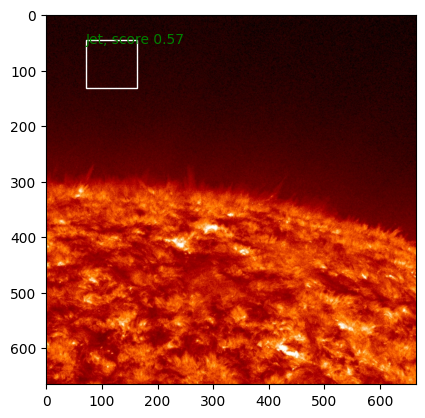

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML
import os

event=6
folder_path = f"./data/vid/Data/VID/VAL/{str(event).zfill(3)}"
file_names = sorted(os.listdir(folder_path))

def read_image_with_bbox(bbox):

    # Read bounding box coordinates (replace with your actual values)
    x_min, y_min = bbox[0], bbox[1]
    x_max, y_max = bbox[2], bbox[3]

    # Calculate rectangle width and height
    width = x_max - x_min
    height = y_max - y_min

    return x_min, y_min, width, height

def update(frame):
    # Read image and bounding box for the current frame
    image_file = file_names[frame]
    image_path = os.path.join(folder_path, image_file)
    image = plt.imread(image_path)
    
    # Update the image with the loaded image
    im.set_data(image)

    for rect in rects:
        rect.remove()

    for text in texts:
        text.remove()


    # Create new rectangles
    rects.clear()  # Clear the list of rectangles
    texts.clear()


    for a,bbox in enumerate(final_bbox[frame]):
        x_min, y_min, width, height = read_image_with_bbox(bbox)
        rect_params = {
            'xy': (x_min, y_min),
            'width': width,
            'height': height,
            'linewidth': 1,
            'edgecolor': 'w',
            'facecolor': 'none'
        }
        rect = Rectangle(**rect_params)
        ax.add_patch(rect)
        rects.append(rect)
        text = ax.text(x_min, y_min-15, "Jet, score %0.2f"%(final_scores[frame][a]), ha='left', va='top', color='green')
        texts.append(text)

    return im, 
    
# Create a figure and axis
fig, ax = plt.subplots()

file_path=os.path.join(folder_path, file_names[0])
image = plt.imread(file_path)
# Initialize the animation with the first image
im = plt.imshow(image)
rects = []
texts = []
"""
for i in range(len(final_bbox[0])):
    x_min, y_min, width, height = read_image_with_bbox(final_bbox[0][i])
    # Create the rectangle
    rect_params = {
        'xy': (x_min, y_min),
        'width': width,
        'height': height,
        'linewidth': 1,
        'edgecolor': 'w',
        'facecolor': 'none'
    }
    rect = Rectangle(**rect_params)
    ax.add_patch(rect)
    ax.text(x_min, y_min-15, "Jet, score %0.2f"%(final_scores[0][i]), ha='left', va='top', color='green')"""
# Create the animation
ani = FuncAnimation(fig, update, frames=len(file_names), interval=100)

# Display the animation as a clickable animation in the notebook
HTML(ani.to_jshtml())


Grouped code

[0]
Input shape : torch.Size([12, 3, 600, 600])
12
12


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

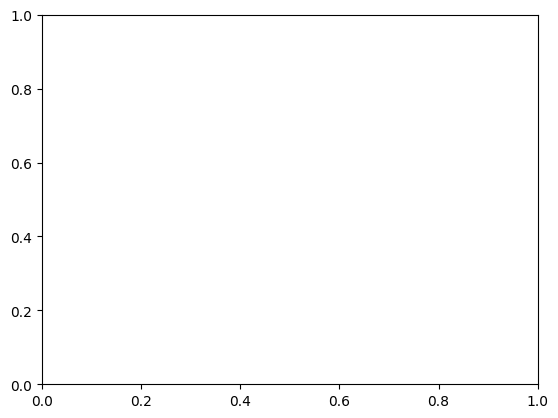

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML
import os
import sys
import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 50  # Set to a larger value (in MB)

event=6 #9,16,17,20

total_events="./data/vid/Data/VID/VAL"
total_events=[folder[-3:] for folder in os.listdir(total_events) if os.path.isdir(os.path.join(total_events, folder))]


if str(event).zfill(3) not in total_events:
    print("Event isn't available")
    sys.exit()
else :
    position=[i for i, x in enumerate(total_events) if x == str(event).zfill(3)]
print(position)
model.eval()
for inputs, targets in data_loader_val:
    if targets[0][0]["image_id"]==1:
        #print(targets)
        inputs = inputs.to(device)
        print("Input shape :", inputs.tensors.shape) #Input should be of size num_frames,3,600,600
        # Forward pass: compute predictions
        with torch.no_grad():  # No need to track gradients during validation
            outputs = model(inputs)
            #print(outputs)
            break #only the first output to see how 

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

target_sizes = torch.tensor([166, 166])
target_sizes = target_sizes.repeat(args.num_frames,1)

out_logits, out_bbox = outputs['pred_logits'].detach().cpu(), outputs['pred_boxes'].detach().cpu()
assert len(out_logits) == len(target_sizes)
assert target_sizes.shape[1] == 2
prob = out_logits.sigmoid()
topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1), 100, dim=1)
scores = topk_values
topk_boxes = topk_indexes // out_logits.shape[2]
labels = topk_indexes % out_logits.shape[2]
boxes = box_cxcywh_to_xyxy(out_bbox)
boxes = torch.gather(boxes, 1, topk_boxes.unsqueeze(-1).repeat(1,1,4))

# and from relative [0, 1] to absolute [0, height] coordinates
img_h, img_w = target_sizes.unbind(1)
scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
boxes = boxes * scale_fct[:, None, :]
results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

final_bbox=[]
final_scores=[]
for results_im in results: #will be executed num_frames times
    threshold=0.39
    bbox_im=[]
    scores_im=[]
    while results_im["scores"][0]>threshold:
        bbox_im.append(results_im["boxes"][0].tolist())
        scores_im.append(results_im["scores"][0].tolist())
        results_im["boxes"]=results_im["boxes"][1:]
        results_im["scores"]=results_im["scores"][1:]
    final_bbox.append(bbox_im)
    final_scores.append(scores_im)
        
print(len(final_bbox)) #should be equal to the number of frames
print(len(final_scores))

folder_path = f"./data/vid/Data/VID/VAL/{str(event).zfill(3)}"
file_names = sorted(os.listdir(folder_path))

def read_image_with_bbox(bbox):

    # Read bounding box coordinates (replace with your actual values)
    x_min, y_min = bbox[0], bbox[1]
    x_max, y_max = bbox[2], bbox[3]

    # Calculate rectangle width and height
    width = x_max - x_min
    height = y_max - y_min

    return x_min, y_min, width, height

def update(frame):
    # Read image and bounding box for the current frame
    image_file = file_names[frame]
    image_path = os.path.join(folder_path, image_file)
    image = plt.imread(image_path)
    
    # Update the image with the loaded image
    im.set_data(image)

    for rect in rects:
        rect.remove()

    for text in texts:
        text.remove()


    # Create new rectangles
    rects.clear()  # Clear the list of rectangles
    texts.clear()


    for a,bbox in enumerate(final_bbox[frame]):
        x_min, y_min, width, height = read_image_with_bbox(bbox)
        rect_params = {
            'xy': (x_min, y_min),
            'width': width,
            'height': height,
            'linewidth': 1,
            'edgecolor': 'w',
            'facecolor': 'none'
        }
        rect = Rectangle(**rect_params)
        ax.add_patch(rect)
        rects.append(rect)
        text = ax.text(x_min, y_min-15, "Jet, score %0.2f"%(final_scores[frame][a]), ha='left', va='top', color='green')
        texts.append(text)

    return im, 
    
# Create a figure and axis
fig, ax = plt.subplots()

file_path=os.path.join(folder_path, file_names[0:args.num_frames])
image = plt.imread(file_path)
# Initialize the animation with the first image
im = plt.imshow(image)
rects = []
texts = []
# Create the animation
ani = FuncAnimation(fig, update, frames=len(file_names), interval=100)

# Display the animation as a clickable animation in the notebook
HTML(ani.to_jshtml())